# Optimisation-based Imputation

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
# import scipy.io
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from util.gmm import EXAMPLE
from util.expectiles import expectile

## Example distribution

We'll want an example multi-modal distribution to play around with.

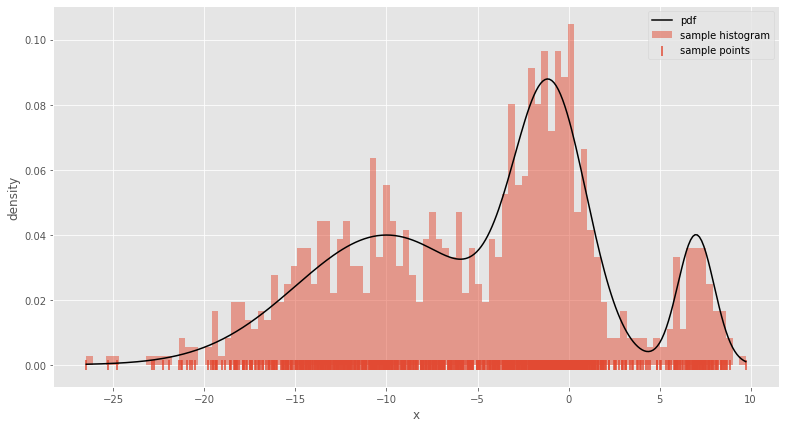

In [2]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

## Imputing expectiles

*Imputation* is the process of 'reconstructing' a distribution given a set of expectiles, so that the distribution has those same expectiles.

Formally, given $\tau_i$ and $\epsilon_{\tau_i}$ for $i = 1, \ldots, K$, we seek a distribution $\eta$ such that for all $i \in \{1,\ldots,K\}$, $\epsilon_{\tau_i} = \text{arg min}_\epsilon ER(\epsilon; \eta, \tau_i)$.

Equivalently, we require that $\frac{\partial}{\partial\epsilon} ER(\epsilon; \eta, \tau_i) |_{\epsilon=\epsilon_{\tau_i}} = 0$ (for all $i \in \{1,\ldots,K\}$), or, framed as an optimisation problem over $\eta$, that

$$
\eta
\in
\text{arg min}_\eta
    \sum_{i=1}^K
    \left(
        \frac{\partial}{\partial\epsilon}
        ER(\epsilon; \eta, \tau_i)
        |_{\epsilon=\epsilon_{\tau_i}}
    \right)^2
$$

Note that given any finite set of expectiles, there may be multiple distributions satisfying the constraints given by those expectiles. We will be satisfied with any such distribution.

In particular, if we assume that the distribution is an empirical distribution on $N$ sample points $z_1, \ldots, z_N$ (with $\eta = \sum_{i=1}^{N} \frac{1}{N} \delta_{z_i}$) then the problem is convex and 'particularly tractable', according to the DeepMind paper (their stochastic expetile distributional reinforcement learning algorithm uses $N=K$ and a default scipy optimiser to solve the problem).

In [5]:
def ER_loss(eps, tau, sample):
    n = len(sample)
    above_loss = 1/n * np.sum(np.square(sample[sample  > eps] - eps))
    below_loss = 1/n * np.sum(np.square(sample[sample <= eps] - eps))
    return tau * above_loss + (1-tau) * below_loss
def grad_eps_half_ER_loss(eps, tau, sample):
    n = len(sample)
    above_grad_loss = 1/n * np.sum(eps - sample[sample  > eps])
    below_grad_loss = 1/n * np.sum(eps - sample[sample <= eps])
    return tau * above_grad_loss + (1-tau) * below_grad_loss
# TODO: I think I could make this more direct using the same kinds of ideas
# as above for the direct computation of the expectiles, and it should
# improve the efficiency of the optimisation process...!

def impute(taus, epss, n, method='min', start='uniform'):
    tes = np.array(list(zip(taus, epss)))

    if start == 'uniform':
        # initialise as uniform distribution between most
        # extreme expectiles
        z0 = np.linspace(epss[0], epss[-1], n)
    elif start == 'bestof1000':
        # this is implemented for 2020 paper to
        # 'significantly improve optimum found'
        # (note: they also repeat this 10 times)
        zs = np.random.uniform(epss[0], epss[-1], (1000, n))
        z0 = zs[np.argmin([sum(ER_loss(e, t, z) for t, e in zip(taus, epss)) for z in zs])]
    if method=='root':
        k = len(tes)
        if n != k:
            raise Exception("Hey! This method requires n=k (number of expectiles)")
        def eps_gradient(sample):
            grad = np.zeros(n)
            grad[:k] = [grad_eps_half_ER_loss(e, t, sample) for t, e in tes]
            return grad
        return opt.root(eps_gradient, x0=z0).x
    elif method=='min':
        def sum_square_grads(sample):
            return sum(grad_eps_half_ER_loss(e, t, sample)**2 for t, e in tes)
        return opt.minimize(sum_square_grads, x0=z0).x

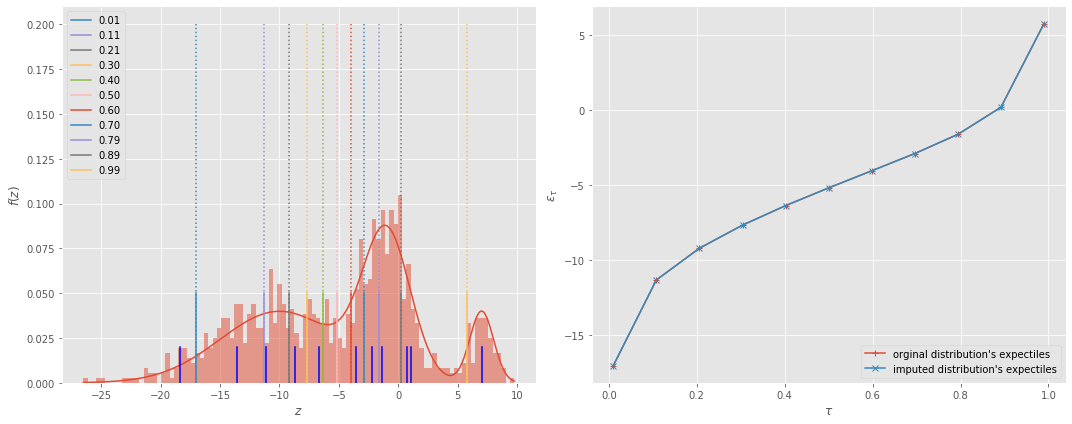

In [7]:
# compute and impute
taus = np.linspace(0.01, 0.99, 11)
epss = expectile(SAMPLE, taus)
imputed_sample = impute(taus, epss, n=len(taus), method='root', start='bestof1000')
imputed_expectiles = expectile(imputed_sample, taus)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# original sample and expectiles

ax1.set_prop_cycle(None)
ax1.hist(SAMPLE, density=1, alpha=0.5, bins=100)
for t, e in zip(taus, epss):
    ax1.plot([e, e], [0, 0.2], linestyle=':')
# new expectiles
ax1.set_prop_cycle(None)
ax1.plot(GMM_X, GMM_Y)
for t, e in zip(taus, imputed_expectiles):
    ax1.plot([e, e], [0, 0.05], label=f"{t:.2f}")
# new sample
for z in imputed_sample:
    ax1.plot([z, z], [0, 0.02], color='blue')
ax1.set_xlabel("$z$")
ax1.set_ylabel("$f(z)$")
ax1.legend(loc="upper left")

# expectiles plot
ax2.plot(taus, epss, marker='+', label='orginal distribution\'s expectiles')
ax2.plot(taus, imputed_expectiles, marker='x', label='imputed distribution\'s expectiles')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\epsilon_\tau$')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [8]:
def compute_and_impute(taus, sample=SAMPLE, n=None, method='min', start='bestof1000'):
    if n is None: n = len(taus)

    # compute
    epss = expectile(sample, taus)
    
    # impute
    imp_samp = impute(taus, epss, n=n, method=method, start=start)
    imp_epss = expectile(imp_samp, taus)

    # plot results:
    # histogram of original sample:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    ax1.hist(sample, density=1, alpha=0.5, bins=100, label="original distribution")
    # imputed sample points:
    for z in imp_samp:
        ax1.plot([z, z], [0, 0.01], color='blue')    
    # gaussian-KDE-smoothed imputed sample distribution:
    imp_dist = stats.gaussian_kde(imp_samp, bw_method=0.2)
    imp_support = np.linspace(min(np.min(sample), np.min(imp_samp)), 
                              max(np.max(sample), np.max(imp_samp)))
    ax1.plot(imp_support, imp_dist.pdf(imp_support), label="imputed distribution (smoothed)")


    ax1.set_xlabel("$z$")
    ax1.set_ylabel("$f(z)$")
    ax1.legend(loc="upper left")

    # expectile comparison plot
    full_taus = np.linspace(0.01, 0.99, 99)
    full_epss_old = expectile(sample, full_taus)
    full_epss_new = expectile(imp_samp, full_taus)
    ax2.plot(full_taus, full_epss_old, label='orginal distribution\'s expectiles')
    ax2.plot(full_taus, full_epss_new,  label='imputed distribution\'s expectiles')
    ax2.scatter(taus, epss, marker='+')
    ax2.scatter(taus, imp_epss, marker='x')
    ax2.set_xlabel(r'$\tau$')
    ax2.set_ylabel(r'$\epsilon_\tau$')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

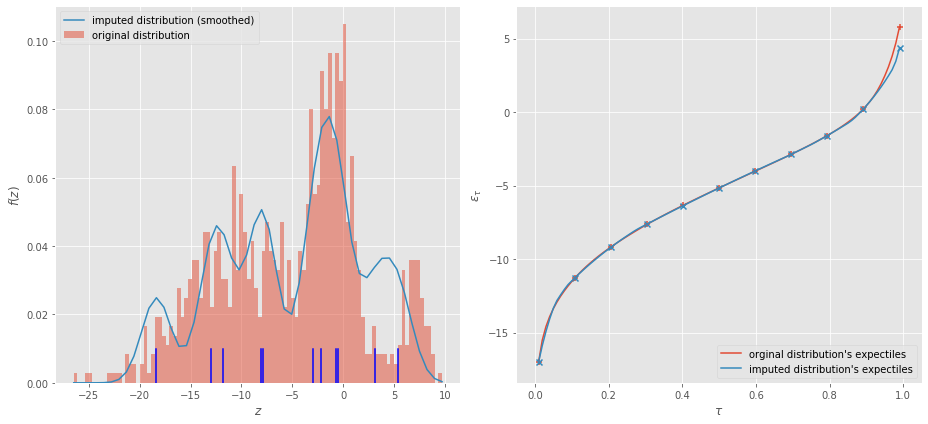

In [9]:
compute_and_impute(taus=np.linspace(0.01, 0.99, 11))

## Playing with the taus

What effect does changing the distribution of expectile biases have on the recovered distribution?

Here I'll use the previously developed sample and imputation methods along with gaussian KDE-smoothing to explore the effect of the tau range on the recovered distribution.

#### What if we nuke the optimistic (or pessimistic) taus?

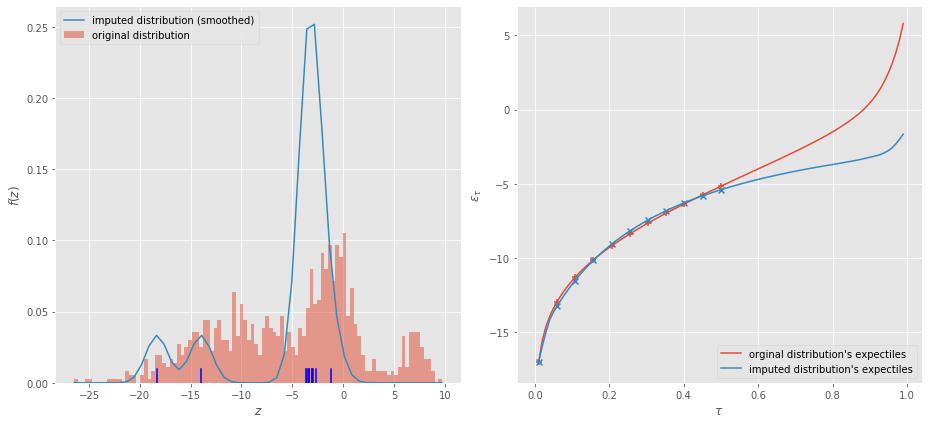

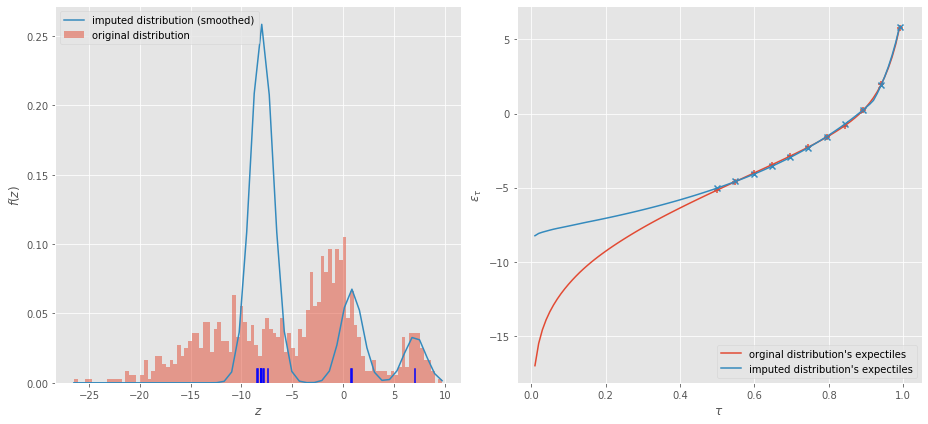

In [10]:
compute_and_impute(taus=np.linspace(0.01, 0.50, 11))
compute_and_impute(taus=np.linspace(0.50, 0.99, 11))

Seems like we struggle to reconstruct a broad distribution, with notable lack of fidelity on the nuked side. What would be the effect on prediction of these distributions?

### What if we restrict the range tightly around the mean?

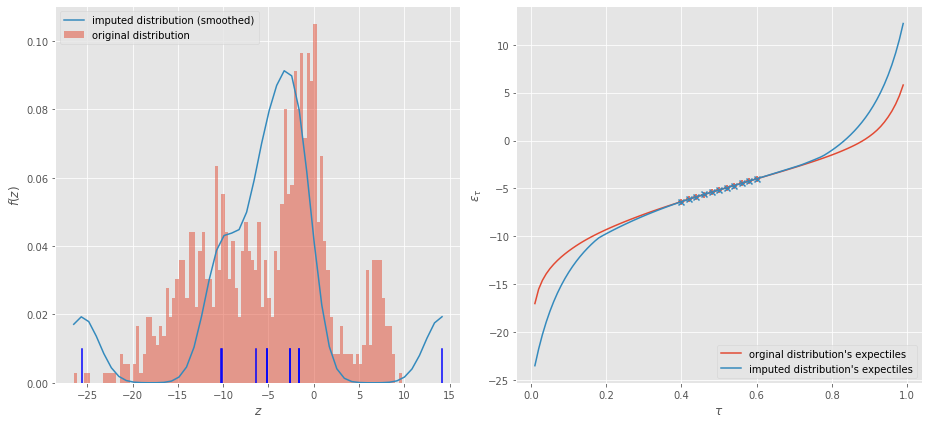

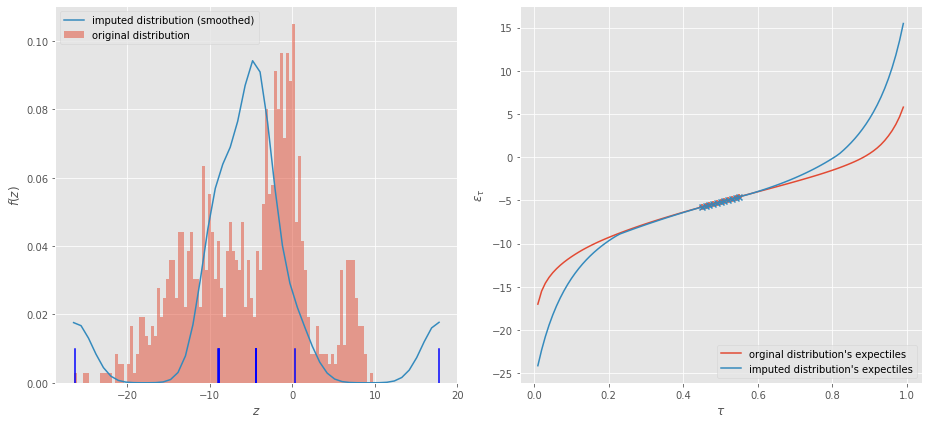

In [11]:
compute_and_impute(taus=np.linspace(0.40, 0.60, 11))
compute_and_impute(taus=np.linspace(0.45, 0.55, 11))

The effect isn't so bad. Well, in the limit, we should recover the mean of the distribution, which was good enough to be state-of-the-art in reinforcement learning until a few years ago!

### What if we use a tight range not including the mean?

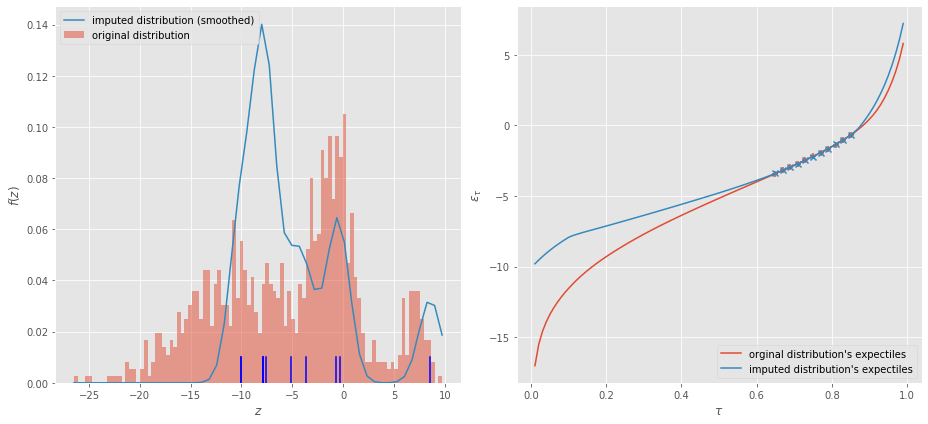

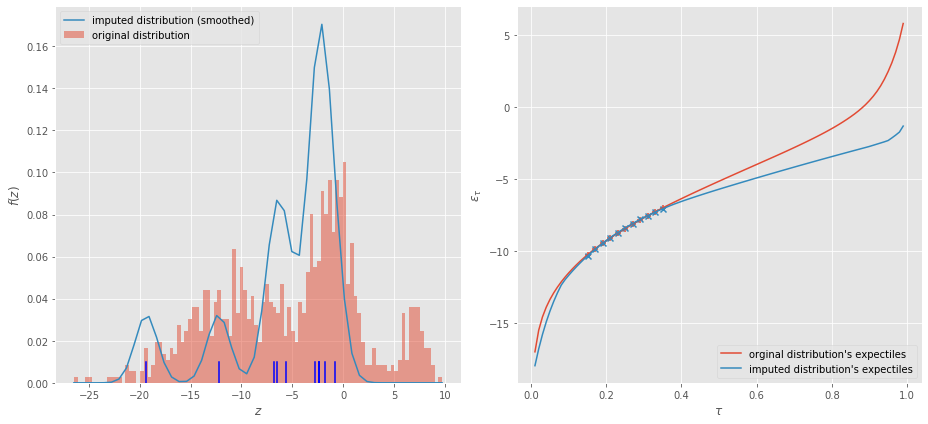

In [12]:
compute_and_impute(taus=np.linspace(0.65, 0.85, 11))
compute_and_impute(taus=np.linspace(0.15, 0.35, 11))

It's like half-way between the other two types.

Notably, it seems that in all cases, we still do a pretty great job of recovering all of the expectiles we kept (how would we go with the ones we didn't keep?).

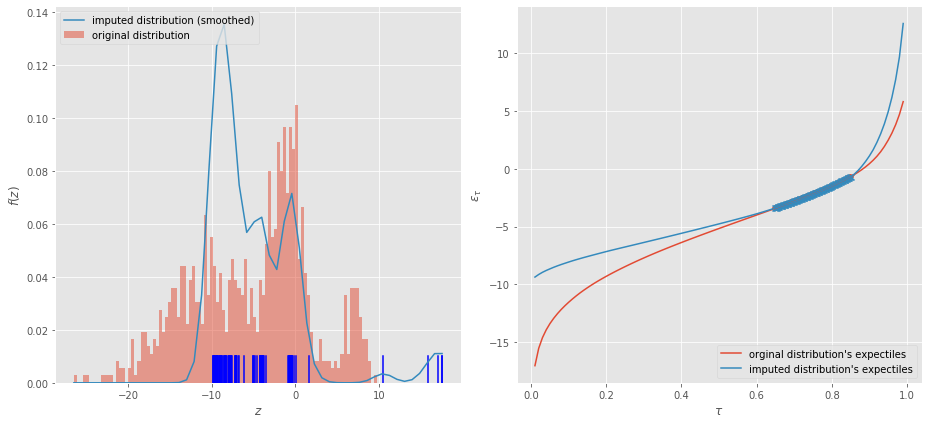

In [13]:
compute_and_impute(taus=np.linspace(0.65, 0.85, 100))